In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Load MIRIAD Dataset

cuda
torch.Size([2, 1, 37, 77, 77])


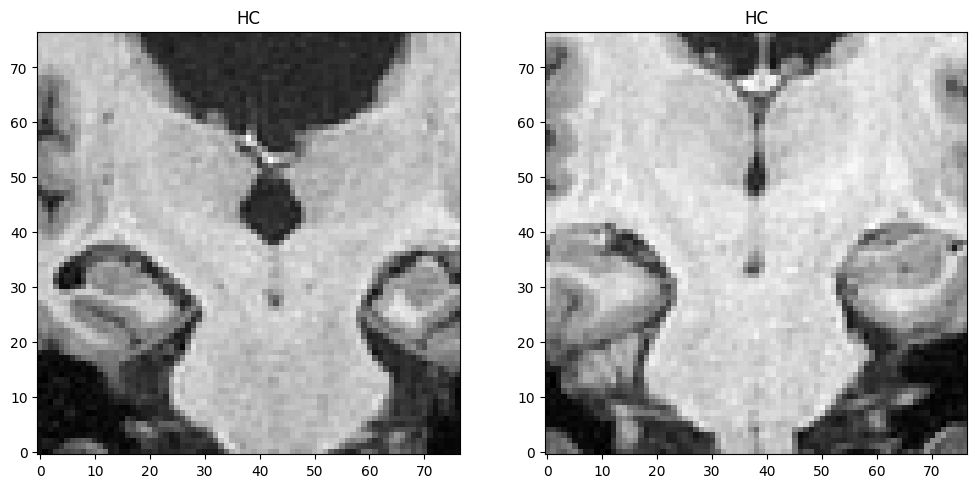

In [5]:
import torchvision.transforms as transforms
from miriad import MiriadDataset
import torch

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)

batch_size=2

train_dataset = MiriadDataset(root="data/miriad", train=True, transform=transform, crop=0.7)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_dataset = MiriadDataset(root="data/miriad", train=False, transform=transform, crop=0.7)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ('HC', 'AD')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

import matplotlib.pyplot as plt

# get some random training images
dataiter = iter(train_loader)
mris, labels = next(dataiter)

print(mris.size())

plt.figure(figsize=(12, 6))
i = 0
for sample_data, sample_label in zip(mris, labels):
    mri_sample_slice = sample_data[0, 16, :, :]
    plt.subplot(1, batch_size, i+1)  # Create a subplot for each sample
    plt.imshow(mri_sample_slice.T, cmap='gray', origin='lower')
    plt.title(f"{classes[sample_label]}")  # Display the label as the title
    i += 1
plt.show()

### 2. 3D-CNN Classification Model

In [3]:
from models import AlzheimersClassification3DCNN

model = AlzheimersClassification3DCNN().double().to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Parameter count = {total_params}")

AlzheimersClassification3DCNN(
  (_conv_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): ReLU()
    (6): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (9): ReLU()
    (10): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): AdaptiveAvgPool3d(output_size=(4, 4, 4))
  )
  (_fc1): Linear(in_features=1024, out_features=256, bias=True)
  (_dropout): Dropout(p=0.2, inplace=False)
  (_fc2): Linear(in

In [18]:
import torch
from training import train, validate
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# training 
import torch.optim as optim
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9, weight_decay=0.001)
epochs = 25

for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_loader,  
                                                criterion, device)
    writer.add_scalars("Loss", {"Training" : float(train_epoch_loss), "Validation": valid_epoch_loss}, epoch)
    writer.add_scalars("Accuracy", {"Training" : train_epoch_acc, "Validation": valid_epoch_acc}, epoch)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

writer.flush()

[INFO]: Epoch 1 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.679, training acc: 50.625
Validation loss: 0.651, validation acc: 55.000
[INFO]: Epoch 2 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.650, training acc: 53.125
Validation loss: 0.614, validation acc: 63.750
[INFO]: Epoch 3 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.612, training acc: 58.125
Validation loss: 0.577, validation acc: 67.500
[INFO]: Epoch 4 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.583, training acc: 63.125
Validation loss: 0.543, validation acc: 71.250
[INFO]: Epoch 5 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.546, training acc: 64.375
Validation loss: 0.509, validation acc: 68.750
[INFO]: Epoch 6 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.506, training acc: 70.625
Validation loss: 0.467, validation acc: 68.750
[INFO]: Epoch 7 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.458, training acc: 77.812
Validation loss: 0.409, validation acc: 80.000
[INFO]: Epoch 8 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.402, training acc: 79.688
Validation loss: 0.383, validation acc: 75.000
[INFO]: Epoch 9 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.358, training acc: 83.750
Validation loss: 0.336, validation acc: 91.250
[INFO]: Epoch 10 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.315, training acc: 88.750
Validation loss: 0.327, validation acc: 81.250
[INFO]: Epoch 11 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.281, training acc: 89.688
Validation loss: 0.321, validation acc: 93.750
[INFO]: Epoch 12 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.247, training acc: 91.562
Validation loss: 0.220, validation acc: 95.000
[INFO]: Epoch 13 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.228, training acc: 90.000
Validation loss: 0.222, validation acc: 88.750
[INFO]: Epoch 14 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.208, training acc: 91.562
Validation loss: 0.181, validation acc: 93.750
[INFO]: Epoch 15 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.170, training acc: 94.062
Validation loss: 0.293, validation acc: 82.500
[INFO]: Epoch 16 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.154, training acc: 96.250
Validation loss: 0.445, validation acc: 72.500
[INFO]: Epoch 17 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.145, training acc: 95.625
Validation loss: 0.935, validation acc: 55.000
[INFO]: Epoch 18 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.140, training acc: 94.688
Validation loss: 0.441, validation acc: 72.500
[INFO]: Epoch 19 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.126, training acc: 95.312
Validation loss: 0.236, validation acc: 93.750
[INFO]: Epoch 20 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.109, training acc: 96.562
Validation loss: 0.143, validation acc: 97.500
[INFO]: Epoch 21 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.103, training acc: 96.562
Validation loss: 0.123, validation acc: 93.750
[INFO]: Epoch 22 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.097, training acc: 96.250
Validation loss: 0.110, validation acc: 96.250
[INFO]: Epoch 23 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.089, training acc: 96.875
Validation loss: 0.444, validation acc: 75.000
[INFO]: Epoch 24 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.079, training acc: 97.812
Validation loss: 0.233, validation acc: 93.750
[INFO]: Epoch 25 of 25
Training


  0%|          | 0/80 [00:00<?, ?it/s]

Validation


  0%|          | 0/20 [00:00<?, ?it/s]

Training loss: 0.072, training acc: 97.812
Validation loss: 0.131, validation acc: 93.750


### 3. Swin-Transformer Classification Model (scratch)

In [2]:
from models import SvinViTAlzheimersClassifier

device = "cuda"

swin_model = SvinViTAlzheimersClassifier().double().to(device)
print(swin_model)
total_params = sum(p.numel() for p in swin_model.parameters())
print(f"Parameter count = {total_params}")

SvinViTAlzheimersClassifier(
  (_svin_vit): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2

In [4]:
import torch
from training import train, validate
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

torch.cuda.empty_cache()

# training 
import torch.optim as optim
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(swin_model.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 25

for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(swin_model, train_loader, 
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc = validate(swin_model, val_loader,  
                                                criterion, device)
    writer.add_scalars("Loss", {"Training" : float(train_epoch_loss), "Validation": valid_epoch_loss}, epoch)
    writer.add_scalars("Accuracy", {"Training" : train_epoch_acc, "Validation": valid_epoch_acc}, epoch)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

writer.flush()

[INFO]: Epoch 1 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.793, training acc: 52.500
Validation loss: 0.766, validation acc: 58.750
[INFO]: Epoch 2 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.738, training acc: 48.125
Validation loss: 0.775, validation acc: 41.250
[INFO]: Epoch 3 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.713, training acc: 50.000
Validation loss: 0.686, validation acc: 58.750
[INFO]: Epoch 4 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.712, training acc: 50.625
Validation loss: 0.746, validation acc: 41.250
[INFO]: Epoch 5 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.714, training acc: 48.125
Validation loss: 0.678, validation acc: 41.250
[INFO]: Epoch 6 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.694, training acc: 53.125
Validation loss: 0.819, validation acc: 58.750
[INFO]: Epoch 7 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.726, training acc: 51.250
Validation loss: 0.794, validation acc: 41.250
[INFO]: Epoch 8 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.702, training acc: 50.000
Validation loss: 0.678, validation acc: 41.250
[INFO]: Epoch 9 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.707, training acc: 50.000
Validation loss: 0.684, validation acc: 41.250
[INFO]: Epoch 10 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.706, training acc: 49.375
Validation loss: 0.682, validation acc: 58.750
[INFO]: Epoch 11 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.714, training acc: 48.125
Validation loss: 0.705, validation acc: 41.250
[INFO]: Epoch 12 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.700, training acc: 50.625
Validation loss: 0.678, validation acc: 41.250
[INFO]: Epoch 13 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.699, training acc: 54.375
Validation loss: 0.763, validation acc: 41.250
[INFO]: Epoch 14 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.703, training acc: 50.000
Validation loss: 0.680, validation acc: 41.250
[INFO]: Epoch 15 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.696, training acc: 50.000
Validation loss: 0.681, validation acc: 41.250
[INFO]: Epoch 16 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.699, training acc: 50.000
Validation loss: 0.687, validation acc: 41.250
[INFO]: Epoch 17 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.710, training acc: 50.000
Validation loss: 0.678, validation acc: 41.250
[INFO]: Epoch 18 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.699, training acc: 52.500
Validation loss: 0.713, validation acc: 41.250
[INFO]: Epoch 19 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.707, training acc: 50.000
Validation loss: 0.710, validation acc: 41.250
[INFO]: Epoch 20 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.702, training acc: 50.000
Validation loss: 0.721, validation acc: 41.250
[INFO]: Epoch 21 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.700, training acc: 50.000
Validation loss: 0.688, validation acc: 41.250
[INFO]: Epoch 22 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.699, training acc: 50.000
Validation loss: 0.680, validation acc: 41.250
[INFO]: Epoch 23 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.700, training acc: 50.000
Validation loss: 0.688, validation acc: 41.250
[INFO]: Epoch 24 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.702, training acc: 50.000
Validation loss: 0.697, validation acc: 41.250
[INFO]: Epoch 25 of 25
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.698, training acc: 50.000
Validation loss: 0.698, validation acc: 41.250


### 4. Swin-Transformer Classification Small Model (scratch)

In [12]:
from models import SvinViTAlzheimersClassifierSmall

device = "cuda"

swin_model_small = SvinViTAlzheimersClassifierSmall().double().to(device)
print(swin_model_small)
total_params = sum(p.numel() for p in swin_model_small.parameters())
print(f"Parameter count = {total_params}")

SvinViTAlzheimersClassifierSmall(
  (_svin_vit): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 8, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=8, out_features=24, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=8, out_features=8, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=8, out_features=16, bias=True)
              (linear2): L

In [13]:
import torch
from training import train, validate
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

torch.cuda.empty_cache()

# training 
import torch.optim as optim
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(swin_model_small.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 30

for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(swin_model_small, train_loader, 
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc = validate(swin_model_small, val_loader,  
                                                criterion, device)
    writer.add_scalars("Loss", {"Training" : float(train_epoch_loss), "Validation": valid_epoch_loss}, epoch)
    writer.add_scalars("Accuracy", {"Training" : train_epoch_acc, "Validation": valid_epoch_acc}, epoch)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

writer.flush()

[INFO]: Epoch 1 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.723, training acc: 50.938
Validation loss: 0.692, validation acc: 47.500
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.708, training acc: 51.875
Validation loss: 0.711, validation acc: 57.500
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.700, training acc: 51.562
Validation loss: 0.696, validation acc: 47.500
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.665, training acc: 55.312
Validation loss: 0.702, validation acc: 55.000
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.551, training acc: 67.500
Validation loss: 0.588, validation acc: 51.250
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.416, training acc: 79.688
Validation loss: 0.420, validation acc: 73.750
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.297, training acc: 88.750
Validation loss: 0.277, validation acc: 87.500
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.195, training acc: 93.750
Validation loss: 0.237, validation acc: 92.500
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.159, training acc: 97.188
Validation loss: 0.229, validation acc: 91.250
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.094, training acc: 99.375
Validation loss: 0.205, validation acc: 91.250
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.071, training acc: 98.750
Validation loss: 0.164, validation acc: 95.000
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.054, training acc: 100.000
Validation loss: 0.206, validation acc: 90.000
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.035, training acc: 100.000
Validation loss: 0.174, validation acc: 93.750
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.025, training acc: 100.000
Validation loss: 0.162, validation acc: 92.500
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.019, training acc: 100.000
Validation loss: 0.159, validation acc: 93.750
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.013, training acc: 100.000
Validation loss: 0.145, validation acc: 93.750
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.011, training acc: 100.000
Validation loss: 0.155, validation acc: 95.000
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.008, training acc: 100.000
Validation loss: 0.159, validation acc: 93.750
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.007, training acc: 100.000
Validation loss: 0.157, validation acc: 95.000
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.006, training acc: 100.000
Validation loss: 0.158, validation acc: 93.750
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.006, training acc: 100.000
Validation loss: 0.159, validation acc: 95.000
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.004, training acc: 100.000
Validation loss: 0.158, validation acc: 93.750
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.004, training acc: 100.000
Validation loss: 0.169, validation acc: 92.500
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.003, training acc: 100.000
Validation loss: 0.165, validation acc: 93.750
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.003, training acc: 100.000
Validation loss: 0.156, validation acc: 93.750
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.002, training acc: 100.000
Validation loss: 0.160, validation acc: 93.750
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.002, training acc: 100.000
Validation loss: 0.176, validation acc: 93.750
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.002, training acc: 100.000
Validation loss: 0.178, validation acc: 91.250
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.003, training acc: 100.000
Validation loss: 0.175, validation acc: 93.750
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Validation


  0%|          | 0/40 [00:00<?, ?it/s]

Training loss: 0.002, training acc: 100.000
Validation loss: 0.174, validation acc: 93.750
